Source: [part 4](https://github.com/bentrevett/pytorch-seq2seq/blob/master/4%20-%20Packed%20Padded%20Sequences%2C%20Masking%2C%20Inference%20and%20BLEU.ipynb)

In [3]:
import os
from IPython.display import Image 

pth = os.getcwd()
pth

'/development/projects/statisticallyfit/github/learningmathstat/PythonNeuralNetNLP/src/NLPstudy'

# 4 - Packed Padded Sequences, Masking and Inference

In this notebook we will be adding a few improvements - packed padded sequences and masking - to the model from the previous notebook. 
**Definition: Packed padded sequences:** are used to tell our RNN to skip over padding tokens in our encoder. 
**Definition: Mask:** A mask explicitly forces the model to ignore certain values, such as attention over padded elements. 

Both of these techniques are commonly used in NLP. 

We will also look at how to use our model for inference, by giving it a sentence, seeing what it translates it as and seeing where exactly it pays attention to when translating each word.

## Preparing Data

Again, the preparation is similar to last time.

First we import all the required modules.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.tensor as Tensor

from torchtext.datasets import TranslationDataset, Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy

import random
import math
import time

In [ ]:
# Set random seeds for reproducibility

SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### 1. Create the Tokenizers

Next, we'll create the tokenizers. A tokenizer is used to turn a string containing a sentence into a list of individual tokens that make up that string, e.g. "good morning!" becomes ["good", "morning", "!"].

spaCy has model for each language ("de" for German and "en" for English) which need to be loaded so we can access the tokenizer of each model.

In [7]:
# Download the spacy models via command line:
# conda activate pynlp_env
# cd /development/.../NLPStudy/data
# python -m spacy download en
# python -m spacy download de

# Then load the models
spacyDE = spacy.load('de')
spacyEN = spacy.load('en')

### 2. Create the Tokenizer Functions

Next, we create the tokenizer functions. These can be passed to TorchText and will take in the sentence as a string and return the sentence as a list of tokens.

In [8]:
# Creating the tokenizer functions
# NOTE: not reversing source (German) anymore.

def tokenizeGerman(germanText: str):
    """
    Tokenizes German text from a string into a list of strings (as tokens)
    :param germanText: 
    :return: 
    """
    return [tok.text for tok in spacyDE.tokenizer(germanText)]

def tokenizeEnglish(englishText: str):
    """
    Tokenizes English text from a string into a list of strings (as tokens)
    and reverses it
    
    :param englishText: 
    :return: 
    """
    return [tok.text for tok in spacyEN.tokenizer(englishText)]

We set the tokenize argument to the correct tokenization function for each, with German being the `SRC` (source) field and English being the `TRG` (target) field. The `Field` also appends the "start of sequence" and "end of sequence" tokens via the `init_token` and `eos_token` arguments, and converts all words to lowercase.

[To read more about Field's arguments](https://github.com/pytorch/text/blob/master/torchtext/data/field.py#L61)

**Difference this time:** When using packed padded sequences, we need to tell PyTorch how long the actual (non-padded) sequences are. TorchText's `Field` objects allow us to use the `include_lengths` argument, which will cause our `batch.src` to be a tuple. The first element of the tuple is the same as before, a batch of numericalized source sentence as a tensor, and the second element is the non-padded lengths of each source sentence within the batch.


In [11]:
# German = source language, English = target language

# tokenize:  The function used to tokenize strings using this field into
#             sequential examples.
# init_token: A token that will be prepended to every example using this
#             field, or None for no initial token. Default: None.
# eos_token: A token that will be appended to every example using this
#             field, or None for no end-of-sentence token. Default: None.
# lower: Whether to lowercase the text in this field. Default: False.
SRC = Field(tokenize = tokenizeGerman,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            include_lengths = True)

TRG = Field(tokenize = tokenizeEnglish,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

### 3. Download the Data

Next, we download and load the train, validation and test data.

The dataset we'll be using is the [Multi30k dataset](https://github.com/multi30k/dataset)

In [12]:
# NOTE: after this, the data is stored in 
# a folder under NLPSTUDY called '.data'
trainData, validationData, testData = Multi30k.splits(exts = ('.de', '.en'),
                                                      fields = (SRC, TRG))

In [13]:
# Print out examples 

# Double-checking we have the right number of examples: 
print(f"Number of training examples: {len(trainData.examples)}")
print(f"Number of validation examples: {len(validationData.examples)}")
print(f"Number of testing examples: {len(testData.examples)}")

print("\n")

# Printing out an example to make sure the source sentence is
# not reversed (if you know German); the target (english) is in proper order, though. 
print(trainData.examples[0])
print(vars(trainData.examples[0]))

Number of training examples: 29000
Number of validation examples: 1014
Number of testing examples: 1000


{'src': ['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.'], 'trg': ['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']}


### 4. Building the vocabulary

Next, we build the *vocabulary* for the source and target languages.

The vocabulary is used to associate each unique token (word) with an index (an integer), similar to the way a dictionary works.

This is used to build a one-hot encoding for each token (a vector of all zeros except for the position represented by the index, which is 1).

The vocabularies of the source and target languages are distinct.

Using the `min_freq` argument, we only allow tokens that appear at least 2 times to appear in our vocabulary. Tokens that appear only once are converted into an `<unk>` (unknown) token.

WARNING: It is important to note that your vocabulary should only be built from the training set and not the validation/test set. This prevents "information leakage" into your model, giving you artifically inflated validation/test scores.

In [14]:
SRC.build_vocab(trainData, min_freq=2)
TRG.build_vocab(trainData, min_freq=2)

In [15]:
print(f"Unique tokens in source (de) vocabulary: {len(SRC.vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(TRG.vocab)}")

Unique tokens in source (de) vocabulary: 7853
Unique tokens in target (en) vocabulary: 5893


### 5. (Final) Create the Iterators

The final step of preparing the data is to create the iterators. These can be iterated on to return a batch of data which will have a `src` attribute (the PyTorch tensors containing a batch of numericalized source sentences) and a `trg` attribute (the PyTorch tensors containing a batch of numericalized target sentences). Numericalized is just a fancy way of saying they have been converted from a sequence of readable tokens to a sequence of corresponding indexes, using the vocabulary.

We also need to define a `torch.device`. This is used to tell TorchText to put the tensors on the GPU or not. We use the `torch.cuda.is_available()` function, which will return `True` if a GPU is detected on our computer. We pass this `device` to the iterator.

When we get a batch of examples using an iterator we need to make sure that all of the source sentences are padded to the same length, the same with the target sentences. Luckily, TorchText iterators handle this for us!

We use a `BucketIterator` instead of the standard `Iterator` as it creates batches in such a way that it minimizes the amount of padding in both the source and target sentences. 

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [18]:
# Creating the training iterator

BATCH_SIZE = 128

trainIterator, validationIterator, testIterator = BucketIterator.splits(
    (trainData, validationData, testData),
    batch_size = BATCH_SIZE,
    sort_within_batch = True, # new key feature
    sort_key = lambda x: len(x.src), # new key feature
    device = device)

## Building the Seq2Seq Model (GRU)

**Overview:** We use a  bidirectional GRU `Encoder` and non-bidirectional GRU `Decoder`.

#### [GRU Formulation](https://hyp.is/FV-GHhAsEeqa9B_lR5PiZg/pytorch.org/docs/stable/nn.html)

For each element in the input sequence, each layer computes the following functions:

\begin{align*}
r_t &= \text{sigmoid}(W_{ir} x_t + b_{ir} + W_{hr} h_{t-1} + b_{hr}) \\
z_t &= \text{sigmoid}(W_{iz} x_t + b_{iz} + W_{hz} h_{t-1} + b_{hz}) \\
n_t &= \text{tanh}(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{t-1} + b_{hn})) \\
h_t &= (1 - z_t) * n_t + z_t + h_{t-1} \\
\end{align*}

##### Variable Meanings in GRU: 
- $x_t$ = the input at time $t$
- $h_t$ = the hidden state at time $t$
- $h_{t-1}$ = the hidden state of the layer at time $t-1$ or the initial hidden state at time $0$.
- $r_t$ = the reset gate. When the reset gate value is close to $0$, the hidden state is forced to ignore the previous hidden state and reset with the current input only. This allows the hidden state to drop any irrelevant information in the future.
- $z_t$ = the update gate. The update gate controls how much information from the previous hidden state carries to the current hidden state, acting like the memory cell in LSMT, to help remember long-term information.
- $n_t$ = the new gate
- $*$ = the Hadamard product

[**NOTE:**](https://hyp.is/XvhiShAyEeqvoV-jOpBdJw/arxiv.org/pdf/1406.1078.pdf) As each hidden unit has separate reset and update gates, each hidden unit can learn to capture dependencies over different time scales. So now we have a hidden unit that adaptively remembers and forgets, determined by time. 
Those units that learn to capture short-term dependencies will have reset gates that are frequently active, but those that capture longer-term dependencies will have update gates that are mostly active. 

- $W_{ih}$ = tensor containing the learnable input-to-hidden weights of the layers. Has shape (3 * `hiddenSize`, `inputSize`) for $k = 0$, else the shape is (3 * `hiddenSize`, `numDirections` * `hiddenSize`). 
- Refers to: 
	- $W_{ir}$ = input-to-hidden weights for all layers for the reset gate
	- $W_{iz}$ = input-to-hidden weights for all layers for the update gate
	- $W_{in}$ = input-to-hidden weights for all layers for the new gate

- $W_{hh}$ = tensor containing the learnable hidden-to-hidden weights of the layers. Has shape (3 * `hiddenSize`, `hiddenSize`). 
- Refers to: 
	- $W_{hr}$ = hidden-to-hidden weights for all layers for the reset gate
	- $W_{hz}$ = hidden-to-hidden weights for all layers for the update gate
	- $W_{hn}$ = hidden-to-hidden weights for all layers for the new gate


- `inputSize` = the number of expected features in the input $X$
- `hiddenSize` = the number of features in the hidden state $h$
- `numLayers` = number of recurrent layers (setting it to 2 means stacking two GRUs to form a *stacked GRU*). 

##### [Inputs of GRU Model:](https://hyp.is/pBfL1BBNEeqtNBe_R-qBnQ/pytorch.org/docs/stable/nn.html)
- `input` = tensor of shape (`seqLen`, `batchSize`, `inputSize`) that contains the features of the input sequence.
- $h_0$ = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the initial hidden state for each element in the batch.

##### [Outputs of GRU Model:](https://hyp.is/srJishBNEeq9gDO7DA-0WQ/pytorch.org/docs/stable/nn.html)
- `output` = tensor of shape (`seqLen`, `batchSize`, `numDirections` * `hiddenSize`) that contains the output features $h_t$ from the last layer of the GRU, for each time step $t$. 
- $h_n$ = `hidden` = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the hidden state for $T =$`seqLen`.


The GRU model (drawing) looks like: 

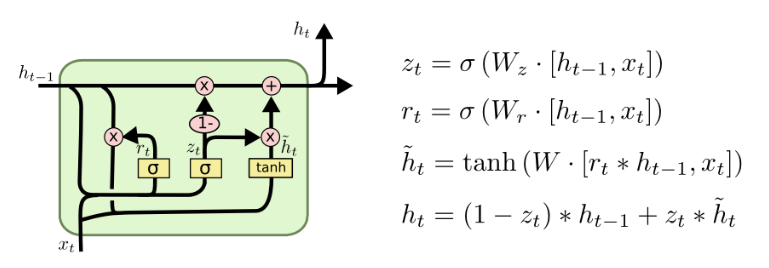

In [19]:
Image(filename = pth + "/images/gru.png")

**NOTE:** the $\tilde{h}_t$ represents the new gate, $n_t$

[Image source](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)




### Encoder

#### Forward Pass of Encoder: 

First, we'll build the encoder. Similar to the previous model, we only use a single layer GRU, however we now use a *bidirectional RNN*.

- **Bidirectional RNN:** there are two RNNs per layer:
- A *forward RNN* going over the sentence from left to right (shown below in green), and
- a *backward RNN* going over the sentence from right to left (yellow).

In PyTorch all we need to do in code is set `bidirectional = True` and then pass the embedded sentence to the RNN as before.

**Key Changes:** The changes this time are all within the `forward` method. It now accepts the lengths of the source sentences as well as the sentences themselves. 

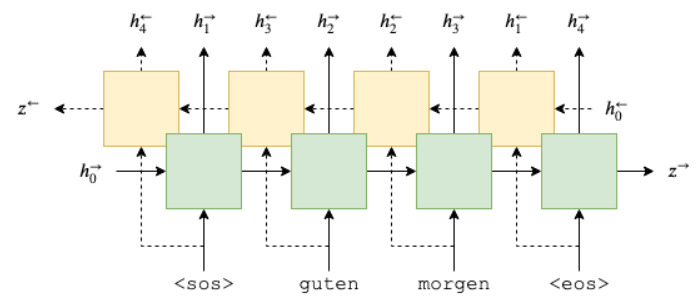

In [13]:
Image(filename= pth + "/images/3_encoderGRU_bidirectional.png")

We now have:

$$
h_t^\rightarrow = \text{EncoderGRU}^\rightarrow(x_t^\rightarrow,h_t^\rightarrow) 
$$
$$
h_t^\leftarrow = \text{EncoderGRU}^\leftarrow(x_t^\leftarrow,h_t^\leftarrow)
$$

where ... 
- $x_0^\rightarrow = \text{<sos>}$
- $x_1^\rightarrow = \text{guten}$ and
- $x_0^\leftarrow = \text{<eos>}$
- $x_1^\leftarrow = \text{morgen}$.





After the source sentence (padded automatically within the iterator) has been embedded, we can then use `pack_padded_sequence` on it with the lengths of the sentences. `packedInputEmbedding` will then be our packed padded sequence. This can be then fed to our RNN as normal which will return `packedOutputs`, a packed tensor containing all of the hidden states from the sequence, and `hidden` which is simply the final hidden state from our sequence. `hidden` is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final **non-padded element** in the sequence.

We then unpack our `packed_outputs` using `pad_packed_sequence` which returns the `outputs` and the lengths of each, which we don't need. 

The first dimension of `outputs` is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.

##### [Inputs of Encoder Bi-directional GRU Model:](https://hyp.is/pBfL1BBNEeqtNBe_R-qBnQ/pytorch.org/docs/stable/nn.html)
- `srcEmbedding` = tensor of shape (`seqLen`, `batchSize`, `inputSize`) that contains the features of the input sequence.
	- This tells PyTorch to initialize both the forward and backward initial hidden states ($h_0^\rightarrow$ and $h_0^\leftarrow$, respectively) to a tensor of all zeros.
- $h_0$ = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the initial hidden state for each element in the batch.(Defaults to zero if we don't pass it, and we don't pass it)

##### [Outputs of Encoder Bi-directional GRU Model:](https://hyp.is/srJishBNEeq9gDO7DA-0WQ/pytorch.org/docs/stable/nn.html)

- `outputs` = tensor of shape (`srcSentenceLen`, `batchSize`, `numDirections` * `hiddenSize`) that contains the output features $h_t$ from the last layer of the GRU, for each time step $t$. 
	- The first `hiddenDim` elements in the third axis are the hidden states from the top layer forward RNN, and the last `hiddenDim` elements are hidden states from the top layer backward RNN. 
	- We can think of the third axis as being the forward and backward hidden states **concatenated** together other: $h_1 = [h_1^\rightarrow; h_{T}^\leftarrow]$, $h_2 = [h_2^\rightarrow; h_{T-1}^\leftarrow]$ , ..., $h_T = [h_T^\rightarrow; h_1^\leftarrow]$ and we can denote all encoder hidden states (forward and backwards concatenated together) as $H=\{ h_1, h_2, ..., h_T\}$.

- $h_n$ = `hidden` = tensor of shape (`numLayers` * `numDirections`, `batchSize`, `hiddenSize`) containing the hidden state for $T =$`seqLen`.
	- **`hidden[-2, :, :]`** gives the top layer forward RNN hidden state after the final time-step (i.e. after it has seen the last word in the sentence). 
		- This is called the context vector from the forward RNN: $z^\rightarrow=h_T^\rightarrow$
	- **`hidden[-1, :, :]`** gives the top layer backward RNN hidden state after the final time-step (i.e. after it has seen the first word in the sentence).
		- This is called the context vector from the backward RNN: $z^\leftarrow=h_T^\leftarrow$


**NOTE: About Combining Context Vectors as Input for `Decoder`:**
As the `Decoder` is not bidirectional, it only needs a single context vector, $z$, to use as its initial hidden state, $s_0$. 
But we currently have two, a forward and a backward one ($z^\rightarrow=h_T^\rightarrow$ and $z^\leftarrow=h_T^\leftarrow$, respectively). 
We solve this by concatenating the two context vectors together, passing them through a linear layer, $g$, and applying the $\tanh$ activation function:

$$
z=\tanh(g(h_T^\rightarrow, h_T^\leftarrow)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0
$$

**WARNING**: this is actually a deviation from the [Neural Translation Paper](https://hyp.is/qr4NUA3lEeqJXwu_KSa8ng/arxiv.org/pdf/1409.0473.pdf). Instead, they feed only the first backward RNN hidden state through a linear layer to get the context vector/decoder initial hidden state. This doesn't seem to make sense to me, so I've changed it.

As we want our model to look back over the whole of the source sentence we return `outputs`, the stacked forward and backward hidden states for every token in the source sentence. We also return `hidden`, which acts as our initial hidden state in the decoder.

In [22]:
class Encoder(nn.Module):
    def __init__(self, inputDim: int, embedDim: int, 
                 encoderHiddenDim: int, decoderHiddenDim: int, 
                 dropout: float):

        super().__init__()

        # NOTE: no dropout since GRU has only 1 layer!
        self.embeddingLayer = nn.Embedding(num_embeddings=inputDim,
                                           embedding_dim=embedDim)

        # This is the linear layer function g() through which we pass the concatenated 
        # hidden states to get the context vector, z
        self.gLinearLayer = nn.Linear(in_features=encoderHiddenDim * 2,
                                      out_features = decoderHiddenDim)
        
        self.gru = nn.GRU(input_size=embedDim, hidden_size=encoderHiddenDim,
                          bidirectional=True)

        # During training, randomly zeroes some of the elements of the input tensor 
        # with probability p using samples from a Bernoulli distribution. Each channel 
        # will be zeroed out independently on every forward call.
        # Good for regularization
        # SOURCE: https://hyp.is/qrKgZg0-EeqHWhNj0dgBjw/pytorch.org/docs/stable/nn.html
        self.dropout = nn.Dropout(dropout)


    def forward(self, src: Tensor, srcLens: Tensor) -> Tensor:
        """
        Passing the source sentence X (tensor) which has been converted into dense vectors
        using the embedding layer. 
        Then apply dropout. 
        Do recurrent calculation of hidden states over the whole sequence.
        
        Computation Graph:

            Convert word indexes to embeddings.
            Pack padded batch of sequences for RNN module.
            Forward pass through GRU.
            Unpack padding.
            Sum bidirectional GRU outputs.
            Return output and final hidden state. 
        
        :param src: tensor X holding the input vectors x_1, ... x_T
            Has shape: (srcSentenceLen, batchSize)
        :param srcLens: tensor holding lengths of src sequences
            shape = (srcLen)    
        :return: 
            outputs: 
            hidden: the final hidden state for each layer, h_T, stacked on top of each other
            This acts as the context vector `z` in the overall Seq2Seq model
        """
        # Convert the source sentence X to dense vectors using embedding layer
        srcEmbedding = self.dropout(self.embeddingLayer(src))
        # srcEmbedding shape: (srcSentenceLen, batchSize, embedDim)


        # After embedding src sentence (padded automatically in iterator), then
        # use pack_padded_sequence  to pack it. (to be able to handle different / 
        # variable length batches efficiently)
        ## DOCS: https://hyp.is/uiNjLBHCEeqTPZ-zOuAmlw/pytorch.org/docs/stable/_modules/torch/nn/utils/rnn.html
        packedSrcEmbeddings = nn.utils.rnn.pack_padded_sequence(
            input = srcEmbedding, lengths = srcLens)
        
        # Feed the packed src embeddings into RNN as usual
        # Get packed outputs, which we need to depack. 
        packedOutputs, hidden = self.gru(input=packedSrcEmbeddings)
        ## packedOutpts is a packed sequence containing all hidden states
        ## hidden is now from the final non-padded element in the batch
        
        # Inverse operation now: 
        # de-pack the packed outputs, returning the outputs and lengths of each
        # of the outputs, whcih we don't need. 
        ## DOCS: https://hyp.is/xZLh9hHCEeq4HMsIoOIfpA/pytorch.org/docs/stable/_modules/torch/nn/utils/rnn.html 
        outputs, _ = nn.utils.rnn.pad_packed_sequence(sequence = packedOutputs)
        ## outputs is now a non-packed sequence, all hidden states obtained when
        # the input is a pad token are all zeros (???) TODO
        ## outputs shape = (srcSentenceLen, batchSize, hiddenDim * numDirections)
        ## hidden shape = (numLayers * numDirections, batchSize, hiddenDim)

        # NOTE: outputs are always from the LAST layer now (instead of top hidden layer)
        
        ### NOTE: hidden is now stacked: [forward_1, backward_1, forward_2, backward_2, ...]
        ### ---> use hidden[-2, :, :] to get the last of the forwards RNN
        ### ---> use hidden[-1, :, :] to get the last of the backwards RNN
        
        # Initial decoder hidden state == final hidden state of forwards and backwards
        # 1. Concatenate the forwards and backwards
        # (this is creating the annotations: 
        # https://hyp.is/LsspQhCFEeqKPGtfX2Y_Xg/arxiv.org/pdf/1409.0473.pdf)
        fwdBackContextTensors: Tensor = torch.cat(
            (hidden[-2, :, :], hidden[-1, :, :]), 
            dim=1)
        # 2. push the encoder RNNs through linear layer, g()
        # 3. push through tanh()
        hidden = torch.tanh(self.gLinearLayer(fwdBackContextTensors))
        
        
        # since numDirections = 2 ... (since Encoder is bidirectional)
        ### outputs shape: (srcSentenceLen, batchSize, encoderHiddenDim * 2)
        ### hidden shape: (batchSize, decoderHiddenDim)
        return outputs, hidden  # context vector
    

### Attention

Next up is the attention layer. The attention module is where we calculate the attention values over the source sentence. 

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using *masking*, we can force the attention to only be over non-padding elements.


#### Forward Pass of Attention: 

**Intuitive Definition of Attention Layer:** 
The attention layer takes in in the previous hidden state of the decoder, $s_{t-1}$ (what has been decoded so far by the `Decoder`) and also takes in all of the stacked forward and backward hidden states from the encoder, $H$ (all of what has been encoded so far by the `Encoder`). 
Then the attention layer uses these to produce an attention vector, $a_t$, that is the length of the source sentence, each element is between 0 and 1 and the entire vector sums to 1. The attention vector $a_t$ represents which words in the source sentence the `Decoder` should pay the most attention to in order to correctly predict the next word to decode, $\hat{y}_{t+1}$. 

**Formula Definition of Attention Layer:**
First, calculate the *energy* $E_t$ between the previous decoder hidden state and the encoder hidden states. As encoder hidden states are a sequence of $T$ tensors, and previous decoder hidden state is a single tensor, the first thing to do is `repeat` the previous decoder hidden state $T$ times. Then calculate the energy, $E_t$, between them by concatenating them and passing the result through a linear layer (`attentionLinearLayer`) and a $\tanh$ activation function:
$$
E_t = \tanh(\text{attentionLinearLayer}(s_{t-1}, H))
$$ 
where $H = \{h_1, h_2, ..., h_T\}$

Intuitively, the energy calculates how well each `Encoder` hidden state "matches" the previous `Decoder` hidden state.

Formulaically, the paper says that the energy $e_{ij} = a(s_{t-1}, h_j)$ is an [alignment model](https://hyp.is/hTdBLBCEEeqNeLtcPGf5lQ/arxiv.org/pdf/1409.0473.pdf) which scores how well the inputs around position $j$ and the output at position $i$ match. This score is based on the RNN hidden state $s_{i-1}$ (just before emitting $y_t$) and the $j$-th annotation $h_j$ of the input sequence. 

**KEY FEATURES:** [The purpose of the alignment is to:](https://hyp.is/koZYmhCEEeqz0ytUsVvYvg/arxiv.org/pdf/1409.0473.pdf)
- compute a "soft alignment" which allows the gradient of the cost function to be backpropagated through. This gradient can be used to train the *alignment model* $e_{tj}$ as well as the whole translation model **jointly**. 
- later compute the probability $\alpha_{tj}$ to implement an attention mechanism in the `Decoder`, so that the `Encoder` is relieved of the burden of having to encode all information in the source sentence into a fixed-length vector. 


We currently have a **(`decoderHiddenDim`, `srcSentenceLen`)** tensor for each example in the batch. We want this to be **(`srcSentenceLen`)** for each example in the batch as the attention should be over the length of the source sentence. This is achieved by multiplying the `energy` by a **(1, `decoderHiddenDim`)** tensor, called $v$:

$$\hat{a}_t = v E_t$$
where $E_t$ represents $e_{tj}$.
This calculates a weighted sum of the "match" over all `decoderHiddenDim` elements for each encoder hidden state, where the weights are learned (while learning the parameters of $v$).

Finally, to ensure the attention vector fits the constraints of having all elements between 0 and 1 and the vector summing to 1, it gets passed through a $\text{softmax}$ layer.

$$
a_t = \text{softmax}(\hat{a_t})
$$

This gives the attention over the source sentence.

- **NOTE:** This is an adapted version of the energy $e_{tj}$ in the paper since in the paper, the energy is pushed directly through the softmax function, but here, we must first multiply by the $v$ vector to get correct dimensions. 
In the paper, the result of energy going through the softmax is the weight $\alpha_{tj}$ of each annotation $h_j$: 

$$
\alpha_{tj} = \frac{e^{e_{tj}}} {\sum_{k = 1}^{T_x} e^{e_{tj}}}
$$

Graphically, this looks something like below. This is for calculating the very first attention vector, where $s_{t-1} = s_0 = z$. The green/yellow blocks represent the hidden states from both the forward and backward RNNs, and the attention computation is all done within the pink block.

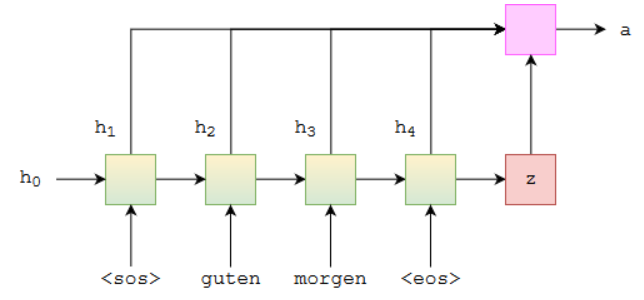

In [16]:
Image(filename = pth + "/images/3_attention.png")

**New Key Feature: Masking**

The `forward` method now takes a `mask` input. This is a **[batch size, source sentence length]** tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the `softmax` function. 
The mask  is applied using `masked_fill`. 
This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given by the second argument (`-1e10`). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be `-1e10`. As these numbers will be miniscule compared to the other values they will become zero when passed through the `softmax` layer, ensuring no attention is payed to padding tokens in the source sentence.

In [23]:
class Attention(nn.Module):
    
    def __init__(self, encoderHiddenDim: int, decoderHiddenDim: int):
        
        super().__init__()
        
        self.attentionLinearLayer = \
            nn.Linear(in_features = encoderHiddenDim * 2 + decoderHiddenDim,
                      out_features=decoderHiddenDim)
        
        # Creating this vector of random numbers just for properly shaping the
        # energy tensor (aesthetic purpose only, for v)
        self.v = nn.Parameter(torch.rand(decoderHiddenDim))
        
    
    def forward(self, hidden: Tensor, 
                encoderOutputs: Tensor, 
                maskTensor: Tensor) -> Tensor:
        """
        
        :param hidden:  
            shape = (batchSize, decoderHiddenDim) 
        :param encoderOutputs: 
            shape = (srcSentenceLen, batchSize, encoderHiddenDim * 2)
        :param mask:
            shape = (`batchSize`, `srcSentenceLen`) tensor **equal to 1 when the 
            source sentence token is not a padding token**, and **equal to 0 when 
            it is a padding token**. 
            
            Example: if the source sentence is: 
            ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], 
            then the mask would be [1, 1, 1, 1, 1, 0, 0].
            
            Source documentation: 
            https://hyp.is/eh0YwBHdEeqh31OC2GfK2w/kite.com/python/docs/torch.Tensor.masked_fill_
        :return: 
        """
        srcSentenceLen, batchSize, _ = encoderOutputs.shape 
        
        # repeat encoder hidden state srcSentenceLen times
        hidden: Tensor = hidden.unsqueeze(1).repeat(1, srcSentenceLen, 1)
        ## hidden shape = (batchSize, srcSentenceLen, decoderHiddenDim)
        
        encoderOutputs: Tensor = encoderOutputs.permute(1, 0, 2)
        ## encoderOutputs shape = (batchSize, srcSentenceLen, encoderHiddenDim * 2)
        
        energy: Tensor = torch.tanh(self.attentionLinearLayer(
            torch.cat((hidden, encoderOutputs), dim = 2)))
        ## energy shape = (batchSize, srcSentenceLen, decoderHiddenDim)
        
        energy: Tensor = energy.permute(0, 2, 1)
        ## energy shape now = (batchSize, decoderHiddenDim, srcSentenceLen)
        
        # V shape currently = (decoderHiddenDim)
        # NOTE: v has aesthetic purpose only, to properly shape the attention vector.
        v: Tensor = self.v.repeat(batchSize, 1).unsqueeze(1)
        ## v shape now = (batchSize, 1, decoderHiddenDim)
        
        # Multiplying v * E_t then removing the dimension 1 to get attention vector
        # of shape (srcSentenceLen)
        attention: Tensor = torch.bmm(v, energy).squeeze(1) 
        ## attention shape = (batchSize, srcLen)
        # TODO: srcLen == srcSentenceLen ????
        # TODO: why is this not the expected shape? (vector)?
        
        # Applying the mask over the attention to decide what is important:
        # This fills the tensor at each element where the first argument (`mask == 0`) is true, with the value given 
        # by the second argument (`-1e10`). In other words, it will take the
        # un-normalized attention values, and change the attention values over 
        # padded elements to be `-1e10`. As these numbers will be miniscule compared 
        # to the other values they will become zero when passed through the `softmax` 
        # layer, ensuring no attention is payed to padding tokens in the source 
        # sentence.
        attention: Tensor = attention.masked_fill(maskTensor == 0, -1e10)
        
        return F.softmax(input = attention, dim = 1)
        

### Decoder

Next up is the decoder. Compared to [part 3](https://github.com/statisticallyfit/PythonNeuralNetNLP/blob/master/src/NLPstudy/Seq2SeqModel/3_NeuralTranslation.ipynb), this `Decoder`  needs only a few small changes: 
1. It needs to accept a mask over the source sentence
2. `Decoder` needs to pass the `mask` to the `Attention` module
3. `Decoder` needs to return the `attention` tensor so we can view the attention values during inference. 

#### Forward Pass of Decoder: 

##### Attention  Mechanism via Context Vector: 

The decoder contains the attention layer, `attention`, which takes the previous hidden state, $s_{t-1}$, all of the encoder hidden states, $H$, and returns the attention vector, $a_t$.

We then use this attention vector to create a weighted source vector, $w_t$, denoted by `weighted`, which is a weighted sum of the encoder hidden states, $H$, using $a_t$ as the weights.

$$w_t = a_t H$$
where $H = \{h_1, ..., h_T\}$ is a tensor containing the hidden states. 

[**Formula Definition of Context Vector:**](https://hyp.is/a4cHvBCEEeqsJlM_ngKoPQ/arxiv.org/pdf/1409.0473.pdf)
The paper calls this weighted sum the context vector:
$$
c_t = \sum_{j=1}^{T_x} \alpha_{tj} h_j
$$ 
The context vector $c_t$ depends on a sequence of annotations (hidden states) $\{h_1, ..., h_{T_x} \}$ to which the `Encoder` maps the input sequence. Each annotation (hidden state) $h_t$ contains information about the whole sentence input sequence with a strong focus on parts surrounding the $i$-th word of the input sequence. 

[**Intuitive Definition of Context Vector:**](https://hyp.is/oJpz5BCEEeqfRyMXGk5sCg/arxiv.org/pdf/1409.0473.pdf)
Intuitively, the context vector can be interpreted as follows: taking a weighted sum of all the annotations (hidden states) $h_j$ means computing an *expected annotation*, where the expectation is over all possible alignments. We have $\alpha_{tj}$ is the probability that the target word $y_t$ is aligned to or translated from a source word $x_j$. Then the $t$-th context vector at time $t$ is $c_t$ is the expected annotation over all the annotations $h_j$ with probabilities $\alpha_{tj}$
The probability $\alpha_{tj}$ or its associated energy $e_{tj}$ reflects the importance of the annotation $h_j$ with respect to the previous hidden state $s_{t-1}$ of the `Decoder` in deciding the next state $s_i$ and generating the target $y_t$. 
This acts as an attention mechanism in the `Decoder`. 
The `Decoder` decides which parts of the source sentence it must pay attention to. 
[**Key purpose:**](https://hyp.is/4h2kThCEEeqXUfPFPlUP2w/arxiv.org/pdf/1409.0473.pdf) By letting the `Decoder` have attention mechanism, we relieve the `Encoder` from the burden of having to encode all information in the source sentence into a fixed-length vector. This way, information can be spread throughout the sequence of annotations which can then be selectively retrieved by the `Decoder`.  



##### [DecoderRNN  Formula:](https://hyp.is/ODSeYBCEEeqsqje0gfKtaA/arxiv.org/pdf/1409.0473.pdf)

The input word (that has been embedded), $y_t$, the weighted source vector, $w_t$, and the previous decoder hidden state, $s_{t-1}$, are then all passed into the decoder RNN, with $y_t$ and $w_t$ being concatenated together.

$$s_t = \text{DecoderGRU}(y_t, w_t, s_{t-1}) $$

We then pass $y_t$, $w_t$ and $s_t$ through the linear layer, $f$, to make a prediction of the next word in the target sentence, $\hat{y}_{t+1}$. This is done by concatenating them all together.

$$\hat{y}_{t+1} = f(y_t, w_t, s_t)$$

The image below shows decoding the first word in an example translation.

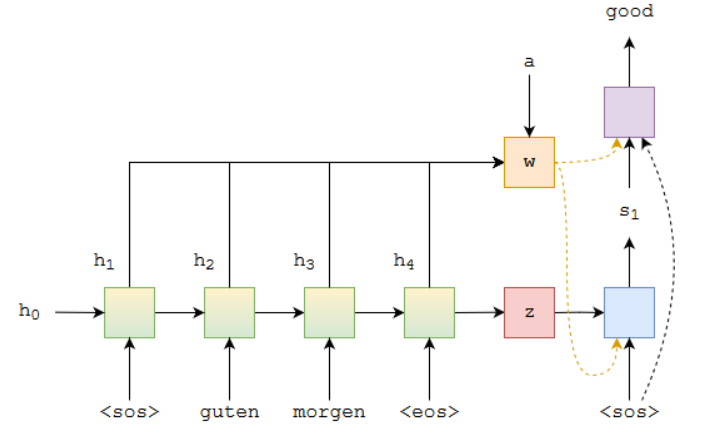

In [33]:
Image(filename = pth + "/images/3_decoderGRU.png")

The green/yellow blocks show the forward/backward encoder RNNs which output $H$, the red block shows the context vector, $z = h_T = \tanh(g(h^\rightarrow_T,h^\leftarrow_T)) = \tanh(g(z^\rightarrow, z^\leftarrow)) = s_0$, the blue block shows the decoder RNN which outputs $s_t$, the purple block shows the linear layer, $f$, which outputs $\hat{y}_{t+1}$ and the orange block shows the calculation of the weighted sum over $H$ by $a_t$ and outputs $w_t$. Not shown is the calculation of $a_t$.

In [25]:
class Decoder(nn.Module):
    
    def __init__(self, outputDim: int, embedDim: int, 
                 encoderHiddenDim: int, decoderHiddenDim: int, dropout: float, 
                 attention: Attention):
        
        super().__init__()
        
        self.outputDim: int = outputDim 
        self.attention: Attention = attention
        
        self.embeddingLayer = nn.Embedding(num_embeddings=outputDim,
                                           embedding_dim=embedDim)
        
        self.gru = nn.GRU(input_size=encoderHiddenDim * 2 + embedDim,
                          hidden_size= decoderHiddenDim)
        
        self.outputLayer = nn.Linear(
            in_features=encoderHiddenDim * 2 + decoderHiddenDim + embedDim,
            out_features=outputDim)
        
        self.dropout = nn.Dropout(dropout)
        
        
        
    def forward(self, input:Tensor, 
                hidden: Tensor, 
                encoderOutputs: Tensor, 
                maskTensor: Tensor) -> (Tensor, Tensor):
        """
        
        :param input: 
            shape = (batchSize)
        :param hidden: 
            shape = (batchSize, decoderHiddenDim)
        :param encoderOutputs: 
            shape = (srcSentenceLen, batchSize, encoderHiddenDim * 2)
        :param mask:
            shape = (`batchSize`, `srcSentenceLen`) tensor **equal to 1 when the 
            source sentence token is not a padding token**, and **equal to 0 when 
            it is a padding token**. 
            
            Example: if the source sentence is: 
            ["hello", "how", "are", "you", "?", `<pad>`, `<pad>`], 
            then the mask would be [1, 1, 1, 1, 1, 0, 0].
            
            Source documentation: 
            https://hyp.is/eh0YwBHdEeqh31OC2GfK2w/kite.com/python/docs/torch.Tensor.masked_fill_
        
        :return: 
        """
        
        input: Tensor = input.unsqueeze(0)
        ## input shape now = (1, batchSize)
        
        inputEmbedding: Tensor = self.dropout(self.embeddingLayer(input))
        ## shape = (1, batchSize, embedDim)
        
        # Calculate attention (result of forward method)
        attn: Tensor = self.attention(hidden=hidden, encoderOutputs = encoderOutputs)
        ## a shape = (batchSize, srcLen)
        attn: Tensor = attn.unsqueeze(1) # add 1-dim tensor at dim = 1
        ## a shape = (batchSize, 1, srcLen)
        
        encoderOutputs: Tensor = encoderOutputs.permute(1, 0, 2)
        ## shape = (batchSize, srcSentenceLen, encoderHiddenDim * 2)
        ## NOTE: meaning of torch.permute(): https://hyp.is/vV91khFMEeqUaP99rnuMeg/kite.com/python/docs/torch.Tensor.permute
        # torch.permute() switches the dimensions of the tensor by referring to the axes / dims
        
        # called 'weighted'
        ## NOTE: meaning of torch.bmm(): https://hyp.is/XqvTdBFMEeqVmoOfrqLXCA/pytorch.org/docs/stable/torch.html
        # Meaning: does batch matrix multiplication: 
        #   if mat1 has size (b, n, m) and mat2 has size (b, m, p), the result of 
        #   torch.bmm(mat1, mat2) is a matrix with size (b, n, p)
        weightedContext: Tensor = torch.bmm(attn, encoderOutputs)
        # weighted context shape = (batchSize, 1, encoderHiddenDim * 2)
        weightedContext: Tensor = weightedContext.permute(1, 0, 2)
        ## shape = (1, batchSize, encoderHiddenDim * 2)
        
        gruInput: Tensor = torch.cat((inputEmbedding, weightedContext), dim = 2)
        ## shape = (1, batchSize, encoderHiddenDIm * 2 + embedDim)
        
        #output, hidden = self.rnn(input = rnnInput, hidden = hidden.unsqueeze(0))
        output, hidden = self.gru(gruInput, hidden.unsqueeze(0))
        ## output shape = (sentenceLen, batchSize, decoderHiddenDim * numDirections)
        ## hidden shape = (numLayers * numDirections, batchSize, decoderHiddenDim)
        ## ------- NOTE: sentenceLen = numLayers = numDirections = 1, so the shapes are:
        ## output shape = (1, batchSize, decoderHiddenDim)
        ## hidden shape = (1, batchSize, decoderHiddenDim)
        ## TODO (?): this also means that output == hidden
        # why are they equal?
        assert (output == hidden).all()
        
        
        # Getting rid of 1-dimensional tensor for all of these
        inputEmbedding: Tensor = inputEmbedding.squeeze(0)
        ## shape = (batchSize, embedDim)
        output: Tensor = output.squeeze(0)
        ## shape = (batchSize, decoderHiddenDim)
        weightedContext: Tensor = weightedContext.squeeze(0)
        ## shape = (batchSize, encoderHiddenDim * 2)
        
        prediction: Tensor = self.outputLayer(
            torch.cat( (output, weightedContext, inputEmbedding), dim=1 )
        )
        # outut shape = (batchSize, outputDim)
        
        # put back 1-dim tensor at position 0
        hidden: Tensor = hidden.squeeze(0) 
        # hidden shape = (1, 1, batchSize, decoderHiddemDim) 
        # ????
        
        # put 1-dim tensor at position 1
        attn: Tensor = attn.squeeze(1)
        # a shape = (batchSize, 1, 1, srcLen)  
        # ????
        
        return prediction, hidden, attn 
        

### Seq2Seq

This is the first model where we don't have to have the `Encoder` RNN and `Decoder` RNN have the same hidden dimensions, however the `Encoder` has to be bidirectional. This requirement can be removed by changing all occurences of `enc_dim * 2` to `enc_dim * 2 if 'encoderIsBidirectional else enc_dim`.
- TODO

This seq2seq encapsulator is similar to the last two. The only differences are that the `Encoder` returns both the:
1. final hidden state (which is the final hidden state from both the forward and backward `Encoder` GRUs passed through a linear layer) to be used as the initial hidden state for the `Decoder`
2. and returns every hidden state (which are the forward and backward hidden states stacked on top of each other). 
3. We also need to ensure that `hidden` and `encoderOutputs` are passed to the `Decoder`.

**Forward Pass of Seq2Seq Model:**
- the `outputs` tensor is created to hold all predictions, $\hat{Y}$
- the source sequence, $X$, and source sequence lengths, `srcLens`, are fed into the `Encoder` to receive $z$ (`encoderOutputs`) and $H$ (`hidden`)
- the initial `Decoder` hidden state is set to be the `context` vector, $s_0 = z = h_T$
- use a batch of `<sos>` tokens as the first `input`, $y_1$
- create the masks from the source sequence tensor
- we then decode within a loop:
	- inserting the input token $y_t$, previous hidden state, $s_{t-1}$, and all `encoderOutputs`, $H$, into the `Decoder`. Also pass in the `mask` tensor. 
	- receiving a prediction, $\hat{y}_{t+1}$, and a new hidden state, $s_t$
	- we then decide if we are going to teacher force or not, setting the next input as appropriate

In [26]:
class Seq2Seq(nn.Module):
    
    def __init__(self, encoder: Encoder, decoder: Decoder, srcPadIndex: Tensor, device):
        
        super().__init__()
        
        self.encoder: Encoder = encoder
        self.decoder: Decoder = decoder
        self.srcPadIndex: Tensor = srcPadIndex
        self.device = device
        
        
        
    def createMask(self, src: Tensor) -> Tensor:
        """
        
        :param src: 
        :return: a mask tensor with values created from where src and pad idnex are
        not equal. Has switched dimensions (permuted dim=1 and dim=0)
        TODO: ?? is src and srcPadIndex binary????
        """
        mask: Tensor = (src != self.srcPadIndex).permute(1, 0)
        return mask 
    
    
        
    def forward(self, srcSeq: Tensor, srcLens: Tensor, 
                trgSeq: Tensor,
                teacherForcingRatio = 0.5) -> Tensor:
        """
        
        :param srcSeq:
            tensor shape = (srcSentenceLen, batchSize)
        :param srcLens: 
            tensor shape = (batchSize) 
        :param trgSeq: 
            shape = (trgSentenceLen, batchSize)
        :param teacherForcingRatio: 
        
        :return: 
        """
        trgLen, batchSize = trgSeq.shape 
        trgVocabSize: int = self.decoder.outputDim 
        
        # tensor to store decoder outputs
        outputs: Tensor = torch.zeros(trgLen, batchSize, trgVocabSize).to(self.device)
        
        ### Encoder outputs is all the hidden states of the input sequence, 
        # backwards and forwads
        ### Hidden is final forward and backward hidden states, after having passed
        # through a linear layer
        # Doing encoder forward pass. 
        encoderOutputs, hidden = self.encoder(srcSeq, srcLens)
        
        # First input to the decoder is the <sos> tokens
        input = trgSeq[0, :]
        
        # Create mask
        mask: Tensor = self.createMask(srcSeq)
        
        
        for t in range(1, trgLen):
            # insert input token embedding, previous hidden state, and all
            # encoder hidden states and mask. 
            # Receive output tensor (predictions) and new hidden state
            output, hidden = self.decoder(input = input, hidden=hidden, 
                                          encoderOutputs = encoderOutputs,
                                          mask = mask)
            
            # Place predictions in a tensor holding predictions for each token
            outputs[t] = output
            
            # Decide if using teacher forcing or not
            useTeacherForce = random.random() < teacherForcingRatio
            
            # Get highest predicted token from our predictions
            maxPredToken = output.argmax(1)
            
            # if teacher forcing, use actual next token (trgSeq[t]) as next input, 
            # else use predicted token (maxPredToken)
            input = trgSeq[t] if useTeacherForce else maxPredToken
            
            
        return outputs 

# Training the Seq2Seq Model

The rest of this tutorial is very similar to the previous one.

## Step 1: Initialize the Seq2Seq (GRU) Model

We initialise our encoder, decoder and seq2seq model (placing it on the GPU if we have one). As before, the embedding dimensions and the amount of dropout used can be different between the encoder and the decoder, but the hidden dimensions must remain the same.

In [33]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]

attn = Attention(encoderHiddenDim=ENC_HID_DIM, decoderHiddenDim=DEC_HID_DIM)

enc = Encoder(inputDim=INPUT_DIM, embedDim=ENC_EMB_DIM, 
              encoderHiddenDim= ENC_HID_DIM, decoderHiddenDim= DEC_HID_DIM, 
              dropout= ENC_DROPOUT)

dec = Decoder(outputDim = OUTPUT_DIM, embedDim=DEC_EMB_DIM, 
              encoderHiddenDim=ENC_HID_DIM, decoderHiddenDim=DEC_HID_DIM, 
              dropout = DEC_DROPOUT, 
              attention=attn)

seqToSeqMaskModel = Seq2Seq(encoder=enc, decoder=dec, device=device,
                                     srcPadIndex=SRC_PAD_IDX).to(device)

In [28]:
enc

Encoder(
  (embeddingLayer): Embedding(7853, 256)
  (gLinearLayer): Linear(in_features=1024, out_features=512, bias=True)
  (gru): GRU(256, 512, bidirectional=True)
  (dropout): Dropout(p=0.5)
)

In [30]:
dec

Decoder(
  (attention): Attention(
    (attentionLinearLayer): Linear(in_features=1536, out_features=512, bias=True)
  )
  (embeddingLayer): Embedding(5893, 256)
  (gru): GRU(1280, 512)
  (outputLayer): Linear(in_features=1792, out_features=5893, bias=True)
  (dropout): Dropout(p=0.5)
)

In [34]:
seqToSeqMaskModel

Seq2Seq(
  (encoder): Encoder(
    (embeddingLayer): Embedding(7853, 256)
    (gLinearLayer): Linear(in_features=1024, out_features=512, bias=True)
    (gru): GRU(256, 512, bidirectional=True)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attentionLinearLayer): Linear(in_features=1536, out_features=512, bias=True)
    )
    (embeddingLayer): Embedding(5893, 256)
    (gru): GRU(1280, 512)
    (outputLayer): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

In [44]:
device

device(type='cpu')

## Step 2: Initialize the Weights of the Seq2Seq Model

We use a simplified version of the weight initialization scheme used in the paper. Here, we will initialize all biases to zero and all weights from $\mathcal{N}(0, 0.01)$.

In [36]:
def initWeights(model: Seq2Seq):
    for  name, param in model.named_parameters():
        if 'weight' in name:
            nn.init.normal_(tensor = param.data, mean=0, std=0.01)
        else: 
            nn.init.constant_(tensor = param.data, val=0)

In [38]:
seqToSeqMaskModel.apply(initWeights)

Seq2Seq(
  (encoder): Encoder(
    (embeddingLayer): Embedding(7853, 256)
    (gLinearLayer): Linear(in_features=1024, out_features=512, bias=True)
    (gru): GRU(256, 512, bidirectional=True)
    (dropout): Dropout(p=0.5)
  )
  (decoder): Decoder(
    (attention): Attention(
      (attentionLinearLayer): Linear(in_features=1536, out_features=512, bias=True)
    )
    (embeddingLayer): Embedding(5893, 256)
    (gru): GRU(1280, 512)
    (outputLayer): Linear(in_features=1792, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5)
  )
)

### Step 3: Print Out Parameters

Define a function to calculate number of trainable parameters in the model.
We get an increase of almost 50% in the amount of parameters from the last model.

In [39]:
def countParameters(model: Seq2Seq):
    # note: trainable parameters means ones that have requires_grad = True
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [40]:
print(f'The model has {countParameters(seqToSeqMaskModel):,} trainable parameters')

The model has 20,518,405 trainable parameters


### Step 4: Initialize the Optimizer (Adam)

In [41]:
adamOptimizer = optim.Adam(seqToSeqMaskModel.parameters())
adamOptimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

### Step 5: Define the Loss Function (Cross Entropy)

Make sure to ignore the loss on `<pad>` tokens.

In [43]:
# PAD_INDEX = TRG.vocab.stoi['<pad>']
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

crossEntropyLossFunction = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
crossEntropyLossFunction

CrossEntropyLoss()

### Step 6: Define the Training Loop

- **NOTE:** same as part 1

Next, we'll define our training loop.

First, we'll set the model into "training mode" with `model.train()`. This will turn on dropout (and batch normalization, which we aren't using) and then iterate through our data iterator.

- **NOTE:**: the `Decoder` loop starts at 1, not 0. This means the 0th element of our `outputs` tensor remains all zeros. So our `trg` and `outputs` look something like:

$$
\text{trg} = [<sos>, y_1, y_2, y_3, <eos>] \\
\text{outputs} = [0, \hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>] \\
$$

Here, when we calculate the loss, we cut off the first element of each tensor to get:

$$
\text{trg} = [y_1, y_2, y_3, <eos>] \\
\text{outputs} = [\hat{y}_1, \hat{y}_2, \hat{y}_3, <eos>] \\
$$

At each iteration:
- get the source and target sentences from the batch, $X$ and $Y$
- zero the gradients calculated from the last batch-feed the source and target into the model to get the output, $\hat{Y}$
- as the **loss function only works on 2d inputs with 1d targets we need to flatten each of them with `.view`**
- we slice off the first column of the output and target tensors as mentioned above
- calculate the gradients with `loss.backward()`
- clip the gradients to prevent them from exploding (a common issue in RNNs)
- update the parameters of our model by doing an optimizer step
- sum the loss value to a running total

Finally, we return the loss that is averaged over all batches.

In [44]:
def train(seqModel: Seq2Seq, iterator, optimizer, lossFunction, clip: int):

    seqModel.train() # put model in training mode

    lossPerEpoch: int = 0

    for epoch, batch in enumerate(iterator):

        # 1. Getting source and target sentences from batch
        srcSentence, srcLens = batch.src
        trgSentence: Tensor = batch.trg

        # 2. Zero the gradients from the last batch
        optimizer.zero_grad()

        # 3. Feed the source and target sentences into the seq2seq model
        # to get the output tensor of predictions.
        output: Tensor = seqModel(srcSeq=srcSentence, 
                                  srcLens = srcLens, 
                                  trgSeq =trgSentence)
        ### trgSentence = tensor of shape (trgSentenceLen, batchSize)
        ### output = tensor of shape (trgSentenceLen, batchSize, outputDim)

        # 4. Need to flatten the outputs to be in 2d input with 1d target
        # so that loss can take this as an argument. 
        # (by slicing off the first column of the output and target tensors
        # as mentioned above)
        outputDim: int = output.shape[-1]
        
        output: Tensor = output[1:].view(-1, outputDim)
        trgSentence: Tensor = trgSentence[1:].view(-1)
        ## trgSentence shape now: ((trgSentenceLen - 1) * batchSize)
        ## output shape now: ((trgSentenceLen - 1) * batchSize, outputDim)

        # 5. Calculate gradients
        loss = lossFunction(input=output, target= trgSentence)
        loss.backward()

        # 6. Clip gradient so it doesn't explode
        torch.nn.utils.clip_grad_norm_(parameters = seqModel.parameters(),
                                       max_norm = clip)

        # 7. Update parameters of model
        optimizer.step()

        # 8. Sum the loss value to a running total
        lossPerEpoch += loss.item()

    return lossPerEpoch / len(iterator) # average loss

### Step 7: Define the Evaluation Loop

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

*We must remember to set the model to evaluation mode with `model.eval()`. This will turn off dropout (and batch normalization, if used).*

We use the `with torch.no_grad()` block to ensure no gradients are calculated within the block. This reduces memory consumption and speeds things up.

The iteration loop is similar (without the parameter updates), however we must ensure we turn teacher forcing off for evaluation. This will cause the model to only use it's own predictions to make further predictions within a sentence, which mirrors how it would be used in deployment.

In [45]:
def evaluate(seqModel: Seq2Seq, iterator, lossFunction):

    seqModel.eval()

    lossPerEpoch = 0

    with torch.no_grad():

        for epoch, batch in enumerate(iterator):
            srcSentence, srcLens = batch.src
            trgSentence: Tensor = batch.trg

            # Turn off teacher forcing
            output: Tensor = seqModel(srcSeq=srcSentence, 
                                      srcLens=srcLens,
                                      trgSeq=trgSentence, 
                                      teacherForcingRatio = 0)
            ## trgSentence = tensor with shape (trgSentenceLen, batchSize)
            ## output = tensor with shape (trgSentenceLen, batchSize, outputDim)
            
            outputDim: int = output.shape[-1]
            
            output: Tensor = output[1:].view(-1, outputDim)
            trgSentence: Tensor = trgSentence[1:].view(-1)
            ## trgSentence = shape is now ((trgSentenceLen - 1) * batchSize)
            ## output = shape is now ((trgSentenceLen - 1) * batchSize, outputDim)

            loss = lossFunction(output, trgSentence)

            lossPerEpoch += loss.item()


    return lossPerEpoch / len(iterator) # average loss

In [46]:
# Time the epoch!

def epochTimer(startTime, endTime):
    elapsedTime = endTime - startTime
    elapsedMins = int(elapsedTime / 60)
    elapsedSecs = int(elapsedTime - (elapsedMins * 60))
    return elapsedMins, elapsedSecs

In [78]:
%%time

NUM_EPOCHS = 10
CLIP = 1

bestValidLoss = float('inf')

for epoch in range(NUM_EPOCHS):

    startTime = time.time()

    trainingLoss = train(seqModel=seqToSeqMaskModel, 
                         iterator=trainIterator,
                         optimizer=adamOptimizer, 
                         lossFunction=crossEntropyLossFunction,
                         clip=CLIP)

    validationLoss = evaluate(seqModel=seqToSeqMaskModel,
                              iterator=validationIterator,
                              lossFunction=crossEntropyLossFunction)

    endTime = time.time()

    epochMins, epochSecs = epochTimer(startTime , endTime)

    if validationLoss < bestValidLoss:
        bestValidLoss = validationLoss
        torch.save(seqToSeqMaskModel.state_dict(), 'tut4_bestModel.pt')


    print(f'Epoch: {epoch+1:02} | Time: {epochMins}m {epochSecs}s')
    print(f'\tTrain Loss: {trainingLoss:.3f} | Train PPL: {math.exp(trainingLoss):7.3f}')
    print(f'\t Val. Loss: {validationLoss:.3f} |  Val. PPL: {math.exp(validationLoss):7.3f}')

In [ ]:
# We'll load the parameters (state_dict) that gave our model the best 
# validation loss and run it the model on the test set.

seqToSeqMaskModel.load_state_dict(torch.load('tut4_bestModel.pt'))

testLoss = evaluate(seqModel=seqToSeqMaskModel, 
                    iterator= testIterator, 
                    lossFunction= crossEntropyLossFunction)

# show test loss and calculate test perplexity score: 
print(f'| Test Loss: {testLoss:.3f} | Test PPL: {math.exp(testLoss):7.3f} |')

## Inference

Now we can use our trained model to generate translations.

**Note:** these translations will be poor compared to examples you see in paper as they use hidden dimension sizes of 1000 and train for 4 days! They have been cherry picked in order to show off what attention should look like on a sufficiently sized model.

Our `translateSentence` will do the following:
- ensure our model is in evaluation mode, which it should always be for inference
- tokenize the source sentence if it has not been tokenized (is a string)
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- get the length of the source sentence and convert to a tensor
- feed the source sentence into the encoder
- create the mask for the source sentence
- create a list to hold the output sentence, initialized with an `<sos>` token
- create a tensor to hold the attention values
- while we have not hit a maximum length
  - get the input tensor, which should be either `<sos>` or the last predicted token
  - feed the input, all encoder outputs, hidden state and mask into the decoder
  - store attention values
  - get the predicted next token
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention values over the sequence

In [47]:
def translateSentence(sentence, srcField: Field, trgField: Field, 
                      seqModel: Seq2Seq, 
                      device, maxLen: int = 50) -> (Tensor, Tensor):
    
    # 1. Put model in evaluation mode as it should be before inference
    seqModel.eval() 
    
    # 2. Tokenize source sentence
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        # make them lowercase
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]
        
    tokens = [srcField.init_token] + tokens + [srcField.eos_token]
    
    # 3. Numericalize the source sentence
    srcIndices = [srcField.vocab.stoi[token] for token in tokens]
    
    # 4. Convert the numericalized source sentence into a tensor and add a batch
    # dimension at dim = 1
    srcSentenceTensor: Tensor = torch.LongTensor(srcIndices).unsqueeze(1).to(device)
    
    # 5. Get the length of the source tensor and convert it into a tensor
    srcLens: Tensor = torch.LongTensor([len(srcIndices)]).to(device)
    
    # 6. Feed the source sentence into the encoder
    #### NOTE: torch.no_grad() impacts the autograd engine and deactivate it. 
    # It will reduce memory usage and speed up computations but you won't be able 
    # to backprop (no need to backprop in an eval script).
    with torch.no_grad():
        encoderOutputs, hidden = seqModel.encoder(srcTensor, srcLens)

We've improved on the previous model, but this came at the cost of doubling the training time.

In the next notebook, we'll be using the same architecture but using a few tricks that are applicable to all RNN architectures - packed padded sequences and masking. We'll also implement code which will allow us to look at what words in the input the RNN is paying attention to when decoding the output.